# Survey Data

Survey Questions:
1. From a scale 1 to 5, how popular is this city? (1 is the least popular and 5 is the most popular)
2. On a scale of 1 to 5, how efficient is this city at turning everyday occurrences into potential viral moments on social media? (1 is the least efficient and 5 is the most efficient)
3. Rate the city's architectural uniqueness from 1 to 5, with 5 being a blend of futuristic wonder and historical charm.
4. Rate the city's enthusiasm for spontaneous street parties on a scale of 1 to 5, with 5 being the life of the celebration.
5. If you were to travel to this city, who would be likely with you?
6. Rank the following words from the least to most relatable to this city. Each area should have a different number assigned to it. (1 is the least relatable and 6 is the most relatable)
7. In your opinion, what is the average temperature of this city over the month of January? (Specify your answer in Celsius)
8. How many different languages might you overhear during a stroll through the city?
9. How many different fashion styles might you spot within a 10-minute walk in the city?
10. What quote comes to mind when you think of this city?

In [37]:
# Imports 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import random

In [38]:
data = pd.read_csv("clean_dataset.csv")

In [39]:
# Helper functions
def to_numeric(s):
  """Converts string `s` to a float.
  Invalid strings and NaN values will be converted to 0.
  """
  if isinstance(s, str):
    s = s.replace(",", '')
    s = pd.to_numeric(s, errors="coerce")
  return float(s)

def get_number_list(s):
  """Get a list of integers contained in string `s`
  """
  return [int(n) for n in re.findall(r"(\d+)", str(s))]

def get_number(s):
  """Get the first number contained in string `s`.
  If `s` does not contain any numbers, return 0.
  """
  n_list = get_number_list(s)
  return n_list[0] if len(n_list) >= 1 else 0

def cat_in_s(s, cat):
  """Return if a category is present in string `s` as an binary integer.
  """
  return int(cat in s) if not pd.isna(s) else 0

def get_cat_ranking(s, cat):
  ranks = s.split(",")

  for r in ranks:
    if cat in r:
      return get_number(r)

  raise Exception("Error get_cat_ranking: invalid category")

def clean_quote(s):
  if isinstance(s, float):
    return ''

  lower = s.lower()
  parse_white_space = re.sub(r'\s+', ' ', lower)
  final = re.sub(r'[^a-z ]', '', parse_white_space)

  return final

def make_bow(quotes, vocab):
  X = np.zeros([len(quotes), len(vocab)])

  for i in range(len(quotes)):
    cleaned_quote = clean_quote(quotes[i])
    words = cleaned_quote.split(" ")

    for j in range(len(vocab)):
      if vocab[j] in words:
        X[i][j] = 1

  return X

# So we can see the data without it being truncated
pd.set_option('display.max_colwidth', None)

In [40]:
# Process and vectorize the data. Here we are using all features except the Q10
data_fets = np.stack([
    data['Q1'].apply(to_numeric).fillna(0),
    data['Q2'].apply(to_numeric).fillna(0),
    data['Q3'].apply(to_numeric).fillna(0),
    data['Q4'].apply(to_numeric).fillna(0),
    data['Q5'].apply(lambda s: cat_in_s(s, "Partner")),
    data['Q5'].apply(lambda s: cat_in_s(s, "Friends")),
    data['Q5'].apply(lambda s: cat_in_s(s, "Siblings")),
    data['Q5'].apply(lambda s: cat_in_s(s, "Co-worker")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Skyscrapers")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Sport")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Art and Music")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Carnival")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Cuisine")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Economic")),
    data['Q7'].apply(to_numeric).fillna(0),
    # data['Q8'].apply(to_numeric).fillna(0),
    # data['Q9'].apply(to_numeric).fillna(0),
], axis=1)

data_label = np.array(data["Label"])

In [41]:
from sklearn.model_selection import train_test_split
# Split data into test, valid, and test set
X = data_fets
t = data_label
X_tv, X_test, t_tv, t_test = train_test_split(X, t, test_size=2/10, stratify=t)
X_train, X_valid, t_train, t_valid= train_test_split(X_tv, t_tv, test_size=2/10, stratify=t_tv)
unique, counts = np.unique(t_train, return_counts=True)
print(dict(zip(unique, counts)))

{'Dubai': 235, 'New York City': 235, 'Paris': 234, 'Rio de Janeiro': 235}


# Neural Networks

## Single Layer

In [42]:
from sklearn.neural_network import MLPClassifier
import os
random_state = 123 # For reproducibility, do not rerun data preparation and keep random_state constant

### relu x layer sizes

In [43]:
s_x = []
s_y = []
s_best_train = 0
s_best_valid = 0
s_best_test = 0
s_best_n = 0
s_coef = None

for i in range(1, 150):
    clf = MLPClassifier(hidden_layer_sizes=(i,), activation="relu", solver="sgd", max_iter=5000, 
                        random_state = random_state)
    clf.fit(X_train, t_train)

    train_acc = clf.score(X_train, t_train)
    valid_acc = clf.score(X_valid, t_valid)
    test_acc = clf.score(X_test, t_test)

    s_x.append(i)
    s_y.append(valid_acc)

    if valid_acc > s_best_valid:
        s_best_valid = valid_acc
        s_best_n = i
        s_best_test = test_acc
        s_best_train = train_acc
        s_coef = clf.coefs_

print(f"Best n_estimator: {s_best_n}")
print(f"Best train accuracy: {s_best_train}")
print(f"Best valid accuracy: {s_best_valid}")
print(f"Best test accuracy: {s_best_test}")

Best n_estimator: 20
Best train accuracy: 0.9052183173588925
Best valid accuracy: 0.9191489361702128
Best test accuracy: 0.8945578231292517


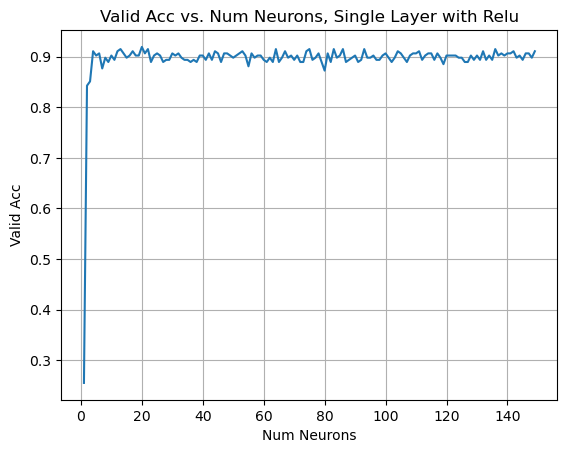

In [44]:
plt.plot(s_x, s_y)
plt.title('Valid Acc vs. Num Neurons, Single Layer with Relu')
plt.xlabel('Num Neurons') 
plt.ylabel('Valid Acc')
plt.grid(True)
plt.show()

### sigmoid(logistic) x layer sizes

In [ ]:
s_x = []
s_y = []
s_best_train = 0
s_best_valid = 0
s_best_test = 0
s_best_n = 0
s_coef = None

for i in range(1, 150):
    clf = MLPClassifier(hidden_layer_sizes=(i,), activation="logistic", solver="sgd", max_iter=5000, 
                        random_state = random_state)
    clf.fit(X_train, t_train)

    train_acc = clf.score(X_train, t_train)
    valid_acc = clf.score(X_valid, t_valid)
    test_acc = clf.score(X_test, t_test)

    s_x.append(i)
    s_y.append(valid_acc)

    if valid_acc > s_best_valid:
        s_best_valid = valid_acc
        s_best_n = i
        s_best_test = test_acc
        s_best_train = train_acc
        s_coef = clf.coefs_

print(f"Best n_estimator: {s_best_n}")
print(f"Best train accuracy: {s_best_train}")
print(f"Best valid accuracy: {s_best_valid}")
print(f"Best test accuracy: {s_best_test}")

In [ ]:
plt.plot(s_x, s_y)
plt.title('Valid Acc vs. Num Neurons, Single Layer with Sigmoid')
plt.xlabel('Num Neurons') 
plt.ylabel('Valid Acc')
plt.grid(True)
plt.show()

### tanh x layer sizes

In [ ]:
s_x = []
s_y = []
s_best_train = 0
s_best_valid = 0
s_best_test = 0
s_best_n = 0
s_coef = None

for i in range(1, 150):
    clf = MLPClassifier(hidden_layer_sizes=(i,), activation="logistic", solver="sgd", max_iter=5000, 
                        random_state = random_state)
    clf.fit(X_train, t_train)

    train_acc = clf.score(X_train, t_train)
    valid_acc = clf.score(X_valid, t_valid)
    test_acc = clf.score(X_test, t_test)

    s_x.append(i)
    s_y.append(valid_acc)

    if valid_acc > s_best_valid:
        s_best_valid = valid_acc
        s_best_n = i
        s_best_test = test_acc
        s_best_train = train_acc
        s_coef = clf.coefs_

print(f"Best n_estimator: {s_best_n}")
print(f"Best train accuracy: {s_best_train}")
print(f"Best valid accuracy: {s_best_valid}")
print(f"Best test accuracy: {s_best_test}")

In [ ]:
plt.plot(s_x, s_y)
plt.title('Valid Acc vs. Num Neurons, Single Layer with tanh')
plt.xlabel('Num Neurons') 
plt.ylabel('Valid Acc')
plt.grid(True)
plt.show()

## Multi Layer

In [33]:
# To be omitted

neurons = 34
multi_x = []
multi_y = []

for i in range(1, 10):
    hls = tuple(neurons for j in range (i))
    clf = MLPClassifier(hidden_layer_sizes=hls, activation='relu', solver='sgd', max_iter=5000, random_state=random_state)
    clf.fit(X_train, t_train)
    train_acc = clf.score(X_train, t_train)
    valid_acc = clf.score(X_valid, t_valid)
    test_acc = clf.score(X_test, t_test)
    multi_x.append(i)
    multi_y.append(valid_acc)

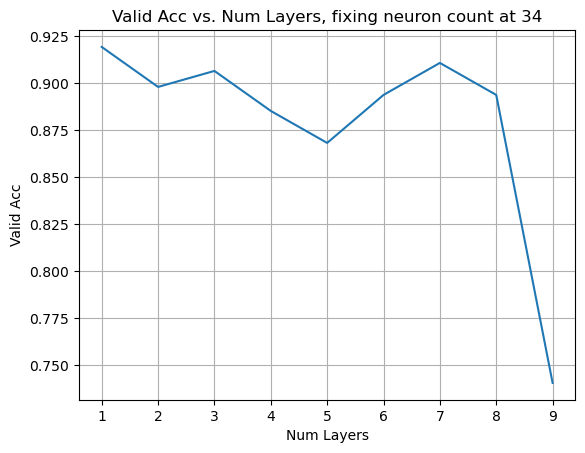

In [34]:
plt.plot(multi_x, multi_y)
plt.title(f'Valid Acc vs. Num Layers, fixing neuron count at {neurons}')
plt.xlabel('Num Layers') 
plt.ylabel('Valid Acc')
plt.grid(True)
plt.show()

## Activation Functions

In [122]:
# to be tuned together with layer size.

functions = ['logistic', 'tanh', 'relu']
neuron_range = 150
n = []
best_activation = []

for j in range(1, neuron_range):
    # For each layer size(neuron count) j, find the activation function producing the best validation acc, and
    # append it to best_activation.
    curr_best_acc = 0
    curr_best_func = ''
    for i in range(len(functions)):
        clf = MLPClassifier(hidden_layer_sizes=(j), activation=functions[i], solver='sgd', max_iter=5000, 
                            random_state=random_state)
        clf.fit(X_train, t_train)
        train_acc = clf.score(X_train, t_train)
        valid_acc = clf.score(X_valid, t_valid)
        test_acc = clf.score(X_test, t_test)
        if valid_acc >= curr_best_acc:
            curr_best_acc = valid_acc
            curr_best_func = functions[i]
    n.append(j)
    best_activation.append(curr_best_func)

print(best_activation) # this just shows for lower layer sizes, logistic is better, and for higher 
# relu and tanh is better

logistic
tanh
logistic
logistic
logistic
tanh
tanh
tanh
logistic
relu
tanh
tanh
tanh
logistic
tanh
tanh
logistic
logistic
logistic
tanh
tanh
tanh
tanh
tanh
relu
logistic
tanh
relu
relu
tanh
tanh
tanh
logistic
tanh
tanh
tanh
tanh
tanh
relu
relu
relu
relu
relu
tanh
tanh
tanh
relu
relu
relu
relu
tanh
tanh
tanh
relu
tanh
tanh
tanh
relu
tanh
tanh
relu
tanh
relu
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
logistic
tanh
tanh
tanh
tanh
relu
relu
relu
tanh
tanh
tanh
relu
tanh
tanh
tanh
tanh
relu
tanh
relu
tanh
tanh
tanh
relu
relu
relu
tanh
relu
tanh
relu
relu
tanh
relu
relu
relu
relu
tanh
relu
relu
tanh
tanh
relu
tanh
tanh
tanh
relu
tanh
tanh
relu
relu
tanh
relu
tanh
relu
tanh
tanh
relu
tanh
tanh
tanh
relu
relu
relu
relu
tanh
relu
tanh
relu
relu
tanh
relu
relu
relu
tanh
tanh
tanh
tanh
relu
relu


In [ ]:
plt.plot(functions, acc)
plt.title(f'Valid Acc vs. Activation Function, fixing neuron count at {neurons}')
plt.xlabel('Activation Function') 
plt.ylabel('Valid Acc')
plt.grid(True)
plt.show()

## Lambda (L2 regularization)

In [121]:
random_state = 123
lamb = [0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1] # possible strengths
acc = []
neurons = 96
for i in range(len(lamb)):
    clf = MLPClassifier(hidden_layer_sizes=(neurons), activation='tanh', solver='sgd', max_iter=5000, 
                        random_state=random_state, alpha=lamb[i])
    clf.fit(X_train, t_train)
    train_acc = clf.score(X_train, t_train)
    valid_acc = clf.score(X_valid, t_valid)
    test_acc = clf.score(X_test, t_test)
    acc.append(valid_acc)

lambda: 0, validation acc: 0.8893617021276595
lambda: 1e-06, validation acc: 0.8936170212765957
lambda: 1e-05, validation acc: 0.8936170212765957
lambda: 0.0001, validation acc: 0.902127659574468
lambda: 0.001, validation acc: 0.8936170212765957
lambda: 0.01, validation acc: 0.8936170212765957
lambda: 0.1, validation acc: 0.8978723404255319
lambda: 1, validation acc: 0.8978723404255319


<IPython.core.display.Javascript object>


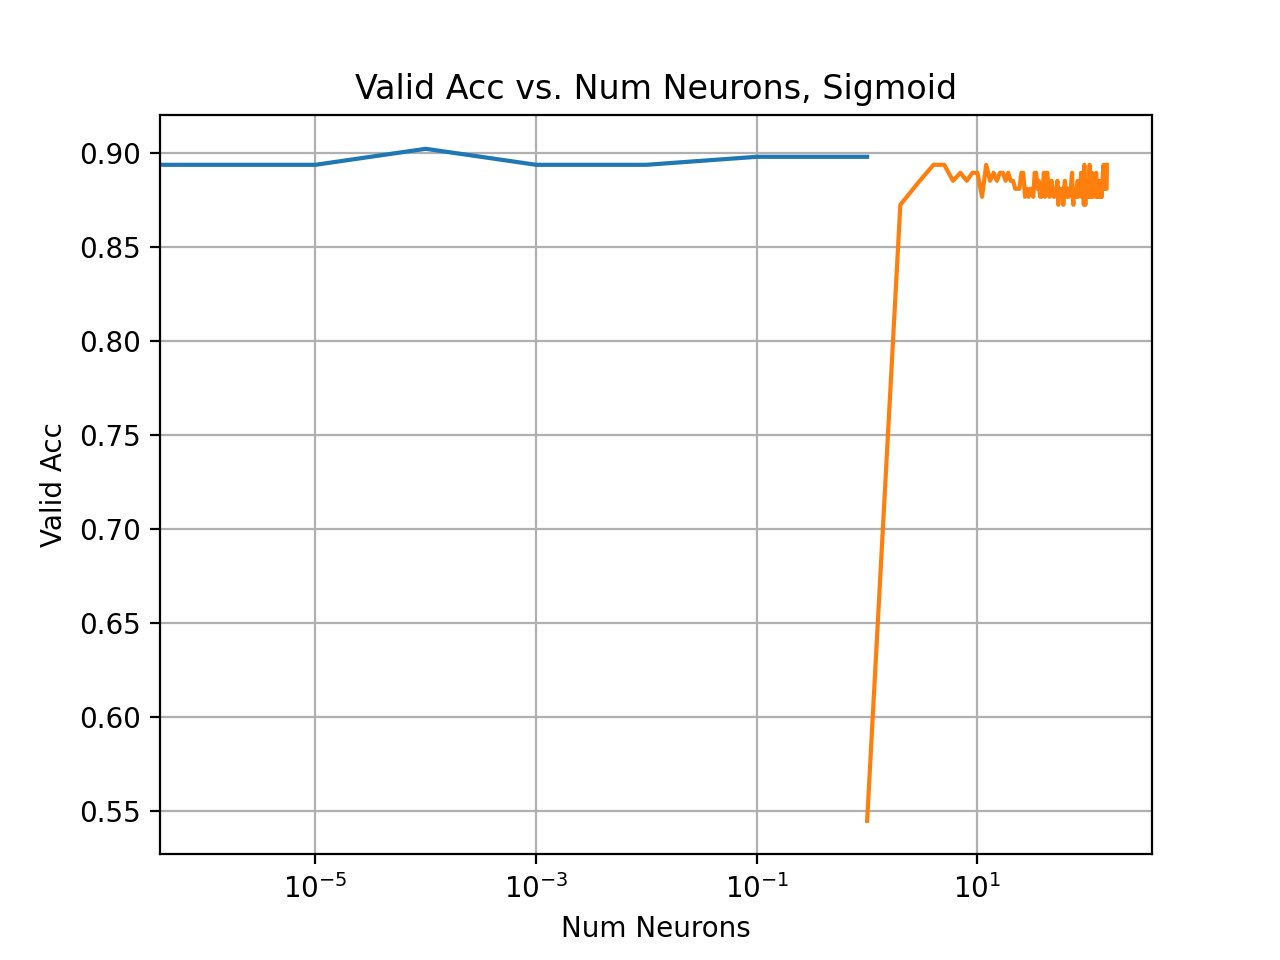

In [120]:
for i in range(len(lamb)):
    print(f'lambda: {lamb[i]}, validation acc: {acc[i]}')

plt.plot(lamb, acc)
plt.title('Valid Acc vs. lambda')
plt.xlabel('lambda')
plt.ylabel('Valid Acc')
plt.grid(True)
plt.xscale('log')  # set the x-axis to a logarithmic scale
plt.show() # graph is messed up, just need to re run.

## Comparing to Random Forests

Best n_estimator: 24
Best train accuracy: 0.8809523809523809
Best valid accuracy: 0.9234042553191489
Best test accuracy: 0.8809523809523809


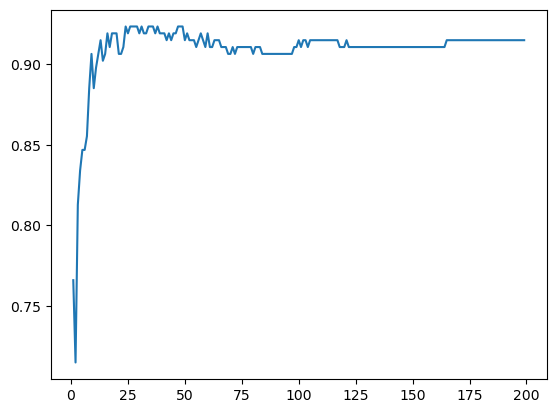

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

clfs = []
x = []
y = []
best_valid = 0
best_test = 0
best_n = 0
best_train = 0
random_state = 123

for i in range(1, 200):
  clf = RandomForestClassifier(n_estimators=i, criterion="entropy", random_state=random_state)
  clf.fit(X_train, t_train)
  clfs.append(clf)

  train_acc = clf.score(X_train, t_train)
  valid_acc = clf.score(X_valid, t_valid)
  test_acc = clf.score(X_test, t_test)

  x.append(i)
  y.append(valid_acc)

  if valid_acc > best_valid:
    best_valid = valid_acc
    best_n = i
    best_test = test_acc
    best_train = test_acc

print(f"Best n_estimator: {best_n}")
print(f"Best train accuracy: {best_train}")
print(f"Best valid accuracy: {best_valid}")
print(f"Best test accuracy: {best_test}")

plt.plot(x, y)
plt.show()      